# Detekcja Porzuconych Obiektów

In [84]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob

from AOD import ObjectDetector, ObjectTracker, detect_static_objects, get_reference_frame

## Konfiguracja

In [85]:
VIDEO_NUM = 1
VIDEO_PATH = f'Videos/Video{VIDEO_NUM}.avi'
OUTPUT_VIDEO_PATH = f'Outputs/AOD_Video{VIDEO_NUM}.avi'
os.makedirs('Outputs', exist_ok=True)
REFERENCE_FRAME_NUM = 1  

MIN_OBJECT_AREA = 50
MAX_OBJECT_AREA = 2000

MOG2_HISTORY = 300
MOG2_VAR_THRESHOLD = 16
MOG2_DETECT_SHADOWS = True

IOU_THRESHOLD = 0.3
IOD_FILTER_THRESHOLD = 0.1
STATIONARY_TIME_THRESHOLD = 300

## Główne przetwarzanie

In [86]:
#┌─────────────┐
#│   Frame     │
#└──────┬──────┘
#       │
#       ├──────────────────────────┐
#       │                          │
#       v                          v
#┌─────────────┐          ┌──────────────────┐
#│ MOG2 apply  │          │ detect_static    │
#│   ↓         │          │ (vs reference)   │
#│ fgMask      │          └────────┬─────────┘
#└──────┬──────┘                   │
#       │                          │
#       v                          v
#┌─────────────┐          ┌──────────────────┐
#│ detect_     │          │ static_          │
#│ objects     │          │ candidates       │
#└──────┬──────┘          └────────┬─────────┘
#       │                          │
#       │         IoU              │
#       └──────> Filtering <───────┘
#                   │
#                   v
#          ┌────────────────┐
#          │ static_objects │
#          │ (oczyszczone)  │
#          └────────┬───────┘
#                   │
#                   v
#          ┌────────────────┐
#          │ Tracking       │
#          │ czasowy        │
#          └────────┬───────┘
#                   │
#                   v
#          ┌────────────────┐
#          │ tracked_static │
#          │ (z licznikiem) │
#          └────────┬───────┘
#                   │
#                   v
#          ┌────────────────┐
#          │ Wizualizacja   │
#          │ + Zapis        │
#          └────────────────┘

In [87]:
cap = cv2.VideoCapture(VIDEO_PATH)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video: {frame_width}x{frame_height} @ {fps} FPS")
print(f"Total frames: {total_frames} ({total_frames/fps:.1f} seconds)")

frames_base = f'Frames/Video{VIDEO_NUM}/'
os.makedirs(frames_base, exist_ok=True)

Video: 640x480 @ 29 FPS
Total frames: 2189 (75.5 seconds)


In [88]:
reference_frame = get_reference_frame(cap, REFERENCE_FRAME_NUM)

backSub = cv2.createBackgroundSubtractorMOG2(
    history=MOG2_HISTORY,
    varThreshold=MOG2_VAR_THRESHOLD,
    detectShadows=MOG2_DETECT_SHADOWS
)

Reference frame 1 loaded


In [89]:
detector = ObjectDetector(min_area=MIN_OBJECT_AREA, max_area=MAX_OBJECT_AREA, merge_distance=0)
static_tracker = ObjectTracker(iou_threshold=IOU_THRESHOLD, stationary_threshold=STATIONARY_TIME_THRESHOLD, movement_threshold=5)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, fps, (frame_width, frame_height))
out_fg = cv2.VideoWriter(f'Outputs/AOD_FG_Video{VIDEO_NUM}.avi', fourcc, fps, (frame_width, frame_height))

\n=== STATIONARY DEBUG Frame 800 ===
Tracked objects: 2
Stationary regions: 0


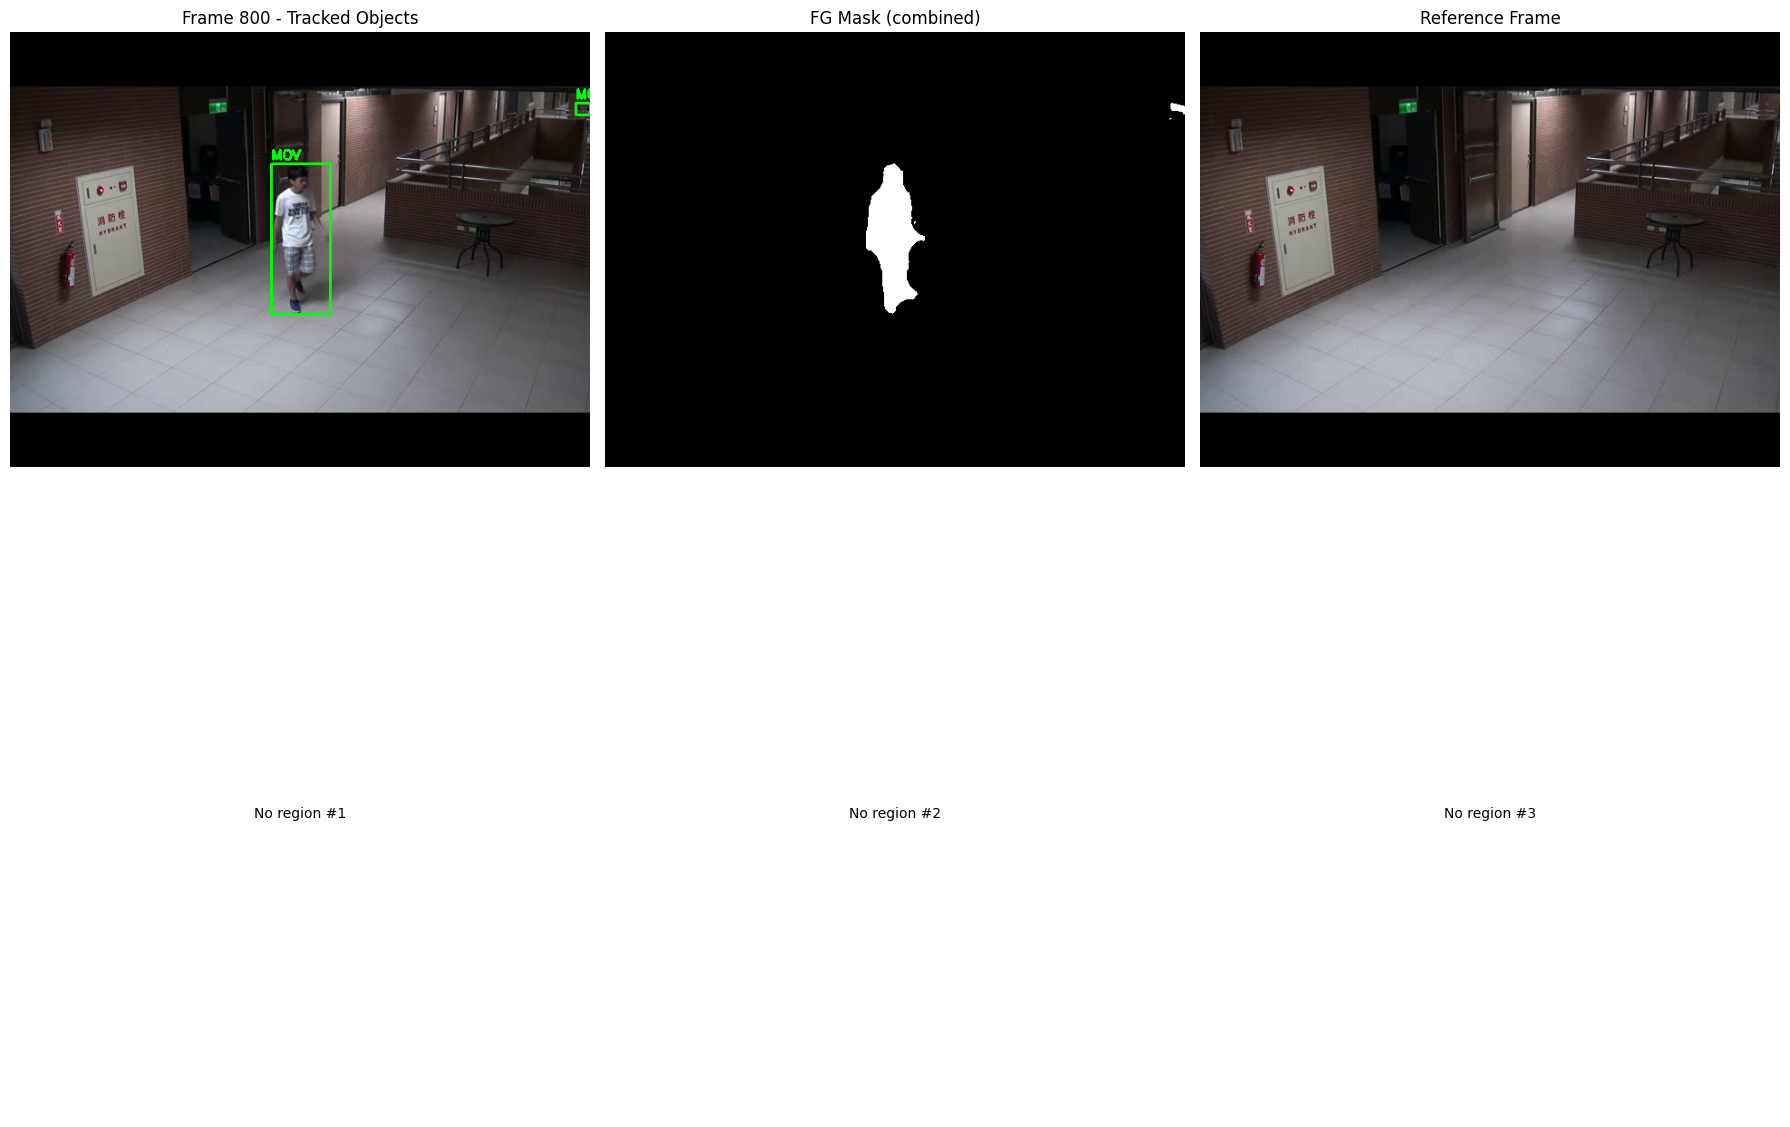

\n=== STATIONARY DEBUG Frame 1000 ===
Tracked objects: 2
Stationary regions: 0


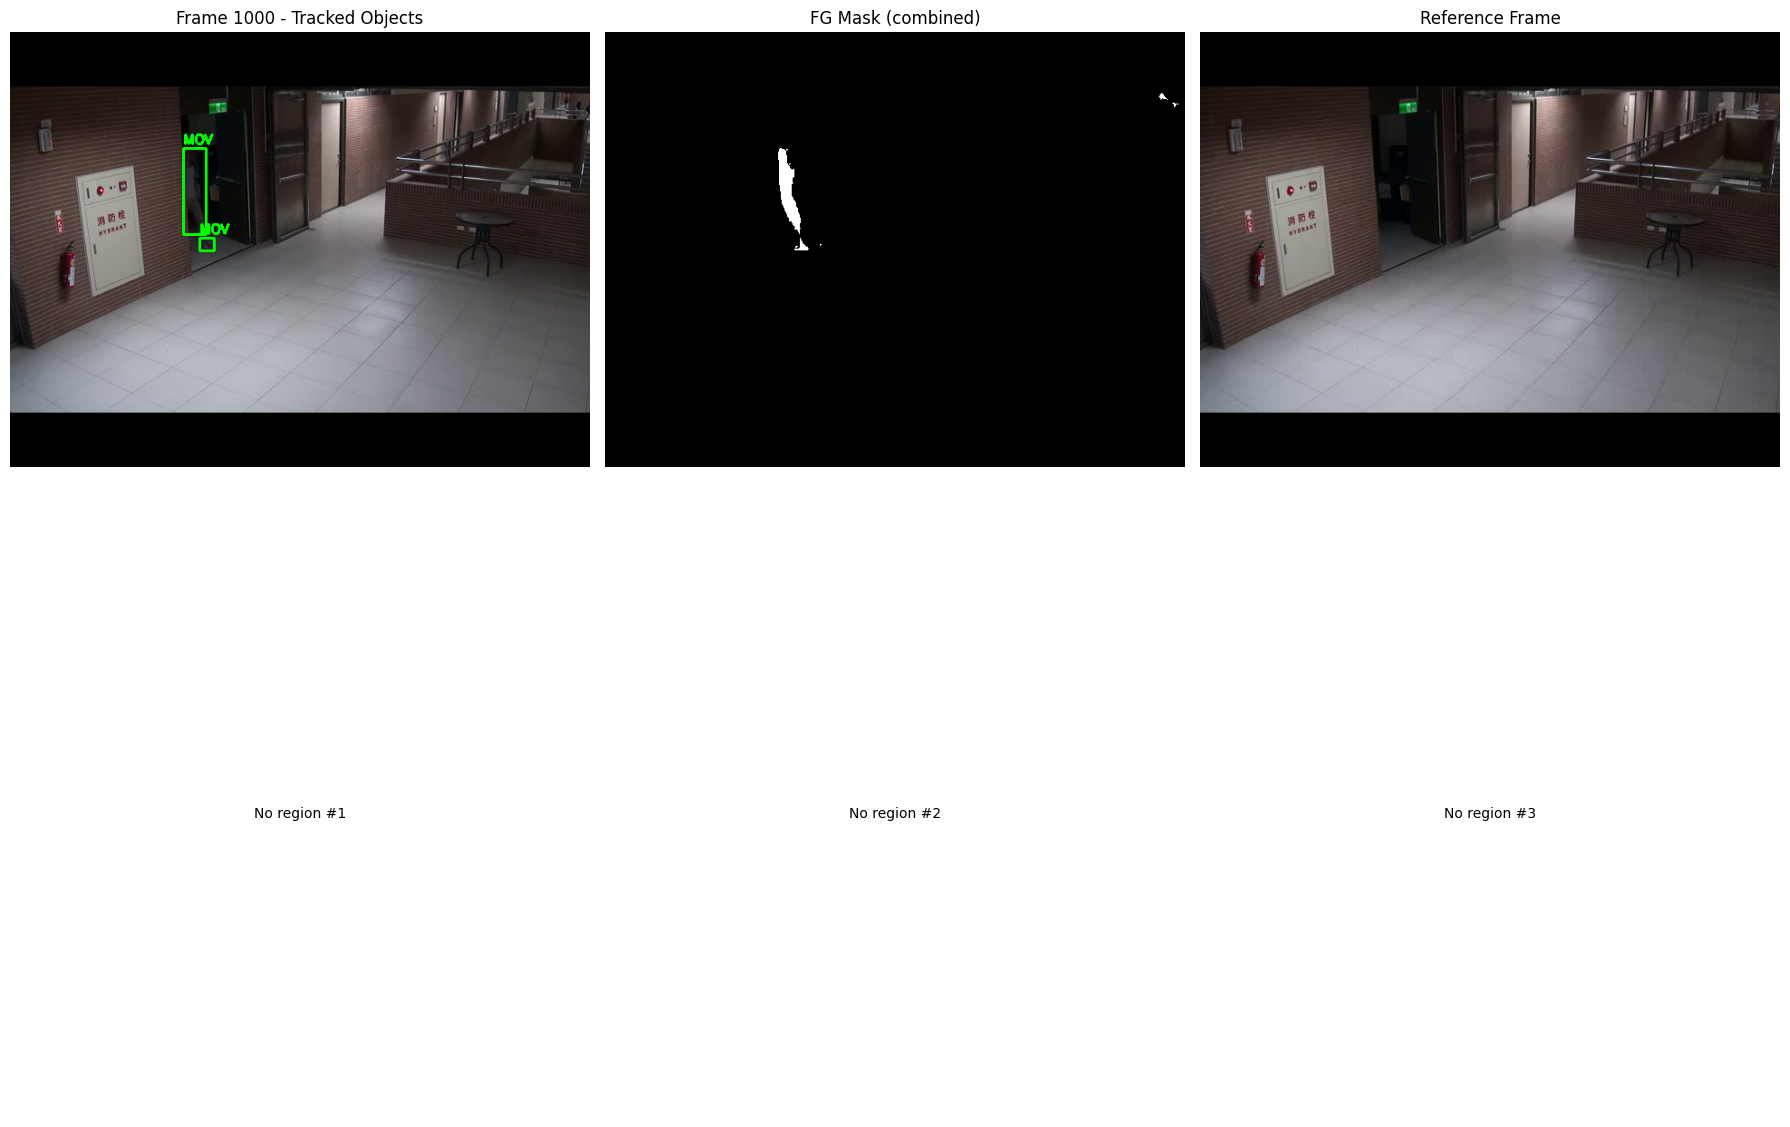

\n=== STATIONARY DEBUG Frame 1200 ===
Tracked objects: 2
Stationary regions: 0


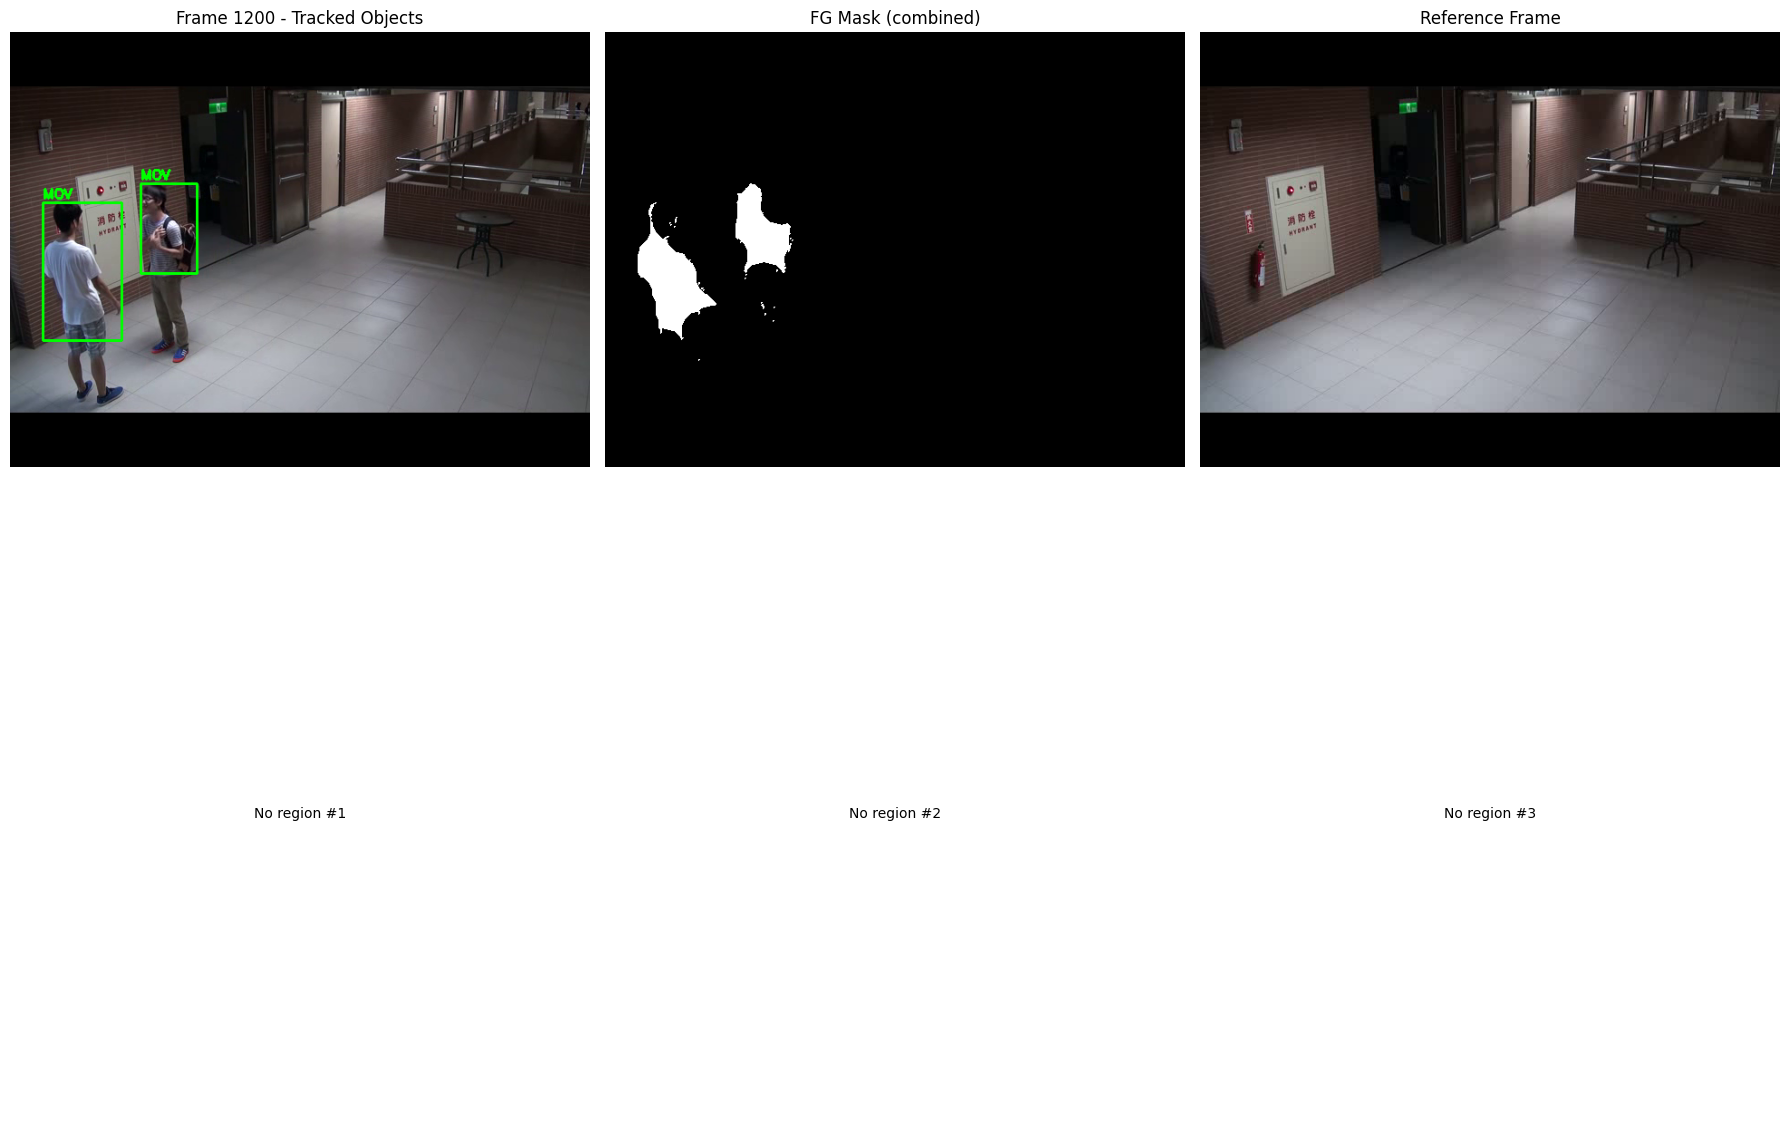

\n=== STATIONARY DEBUG Frame 1500 ===
Tracked objects: 1
Stationary regions: 0


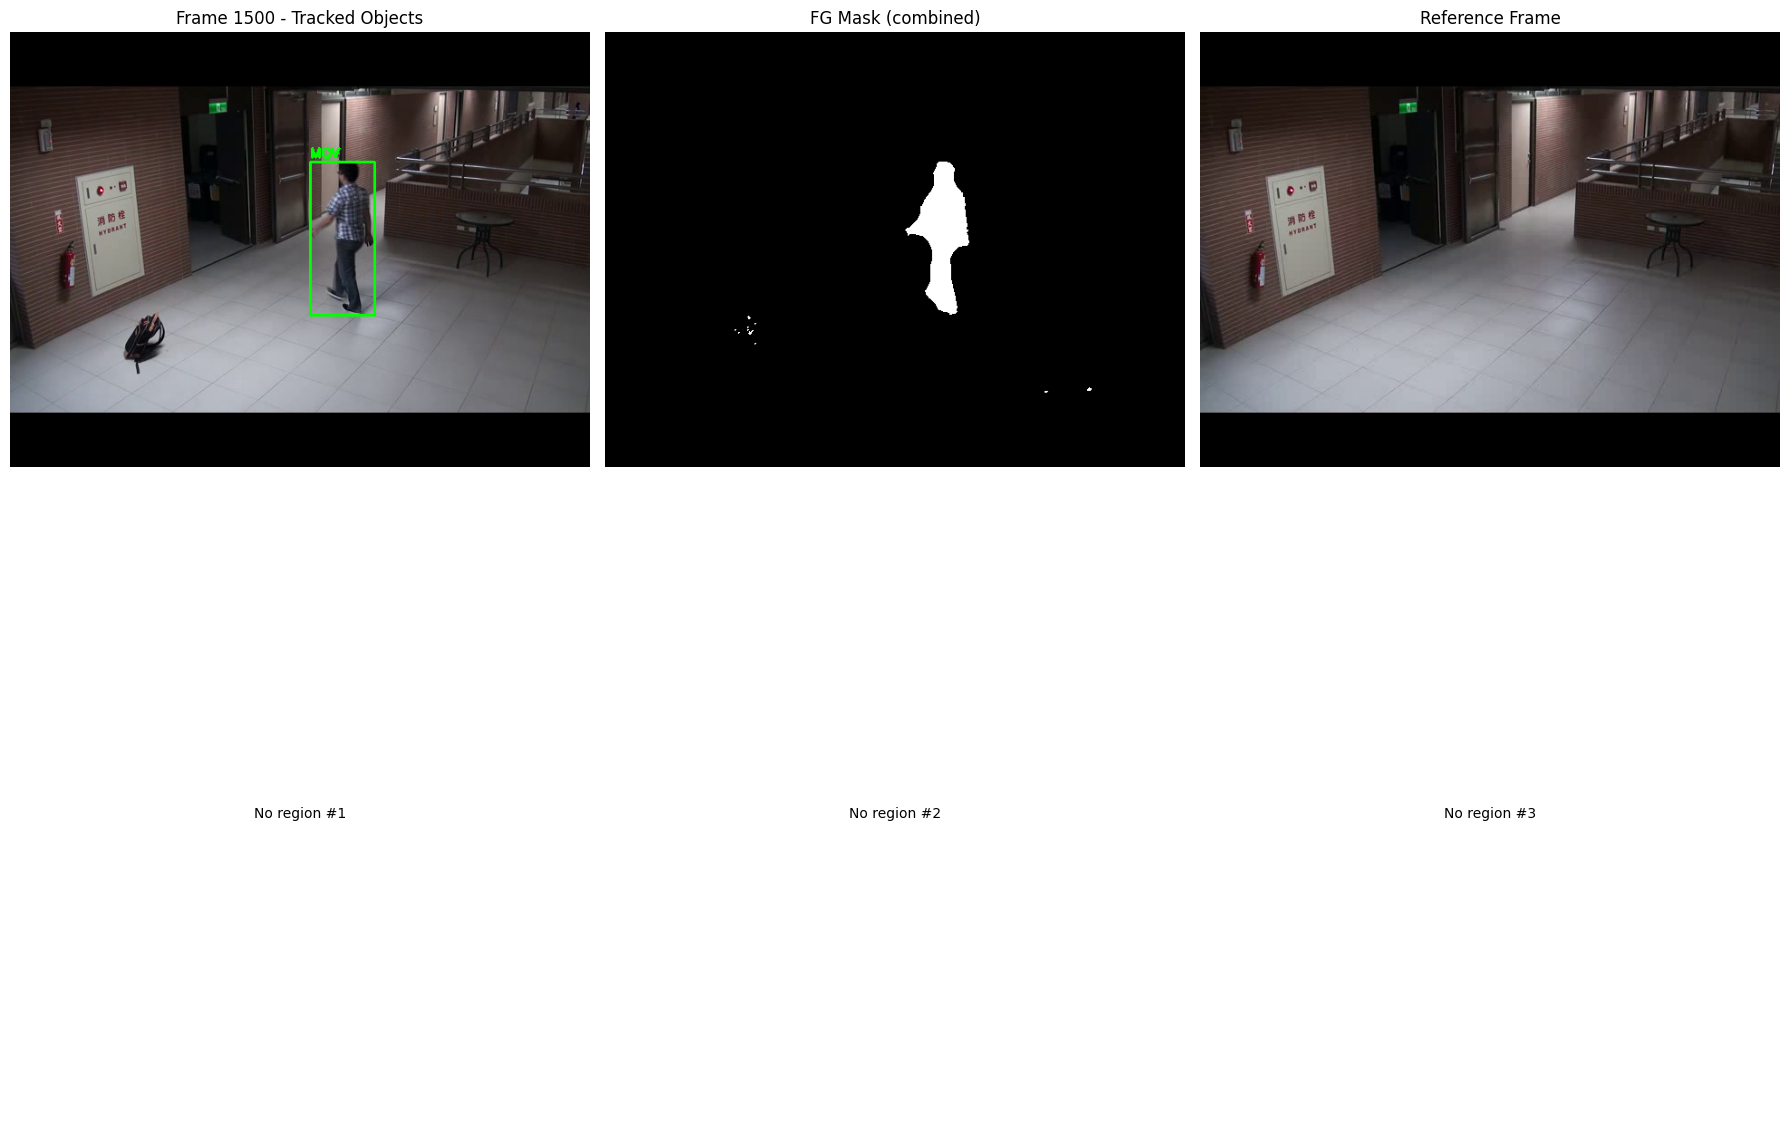

\n=== STATIONARY DEBUG Frame 1800 ===
Tracked objects: 1
Stationary regions: 0


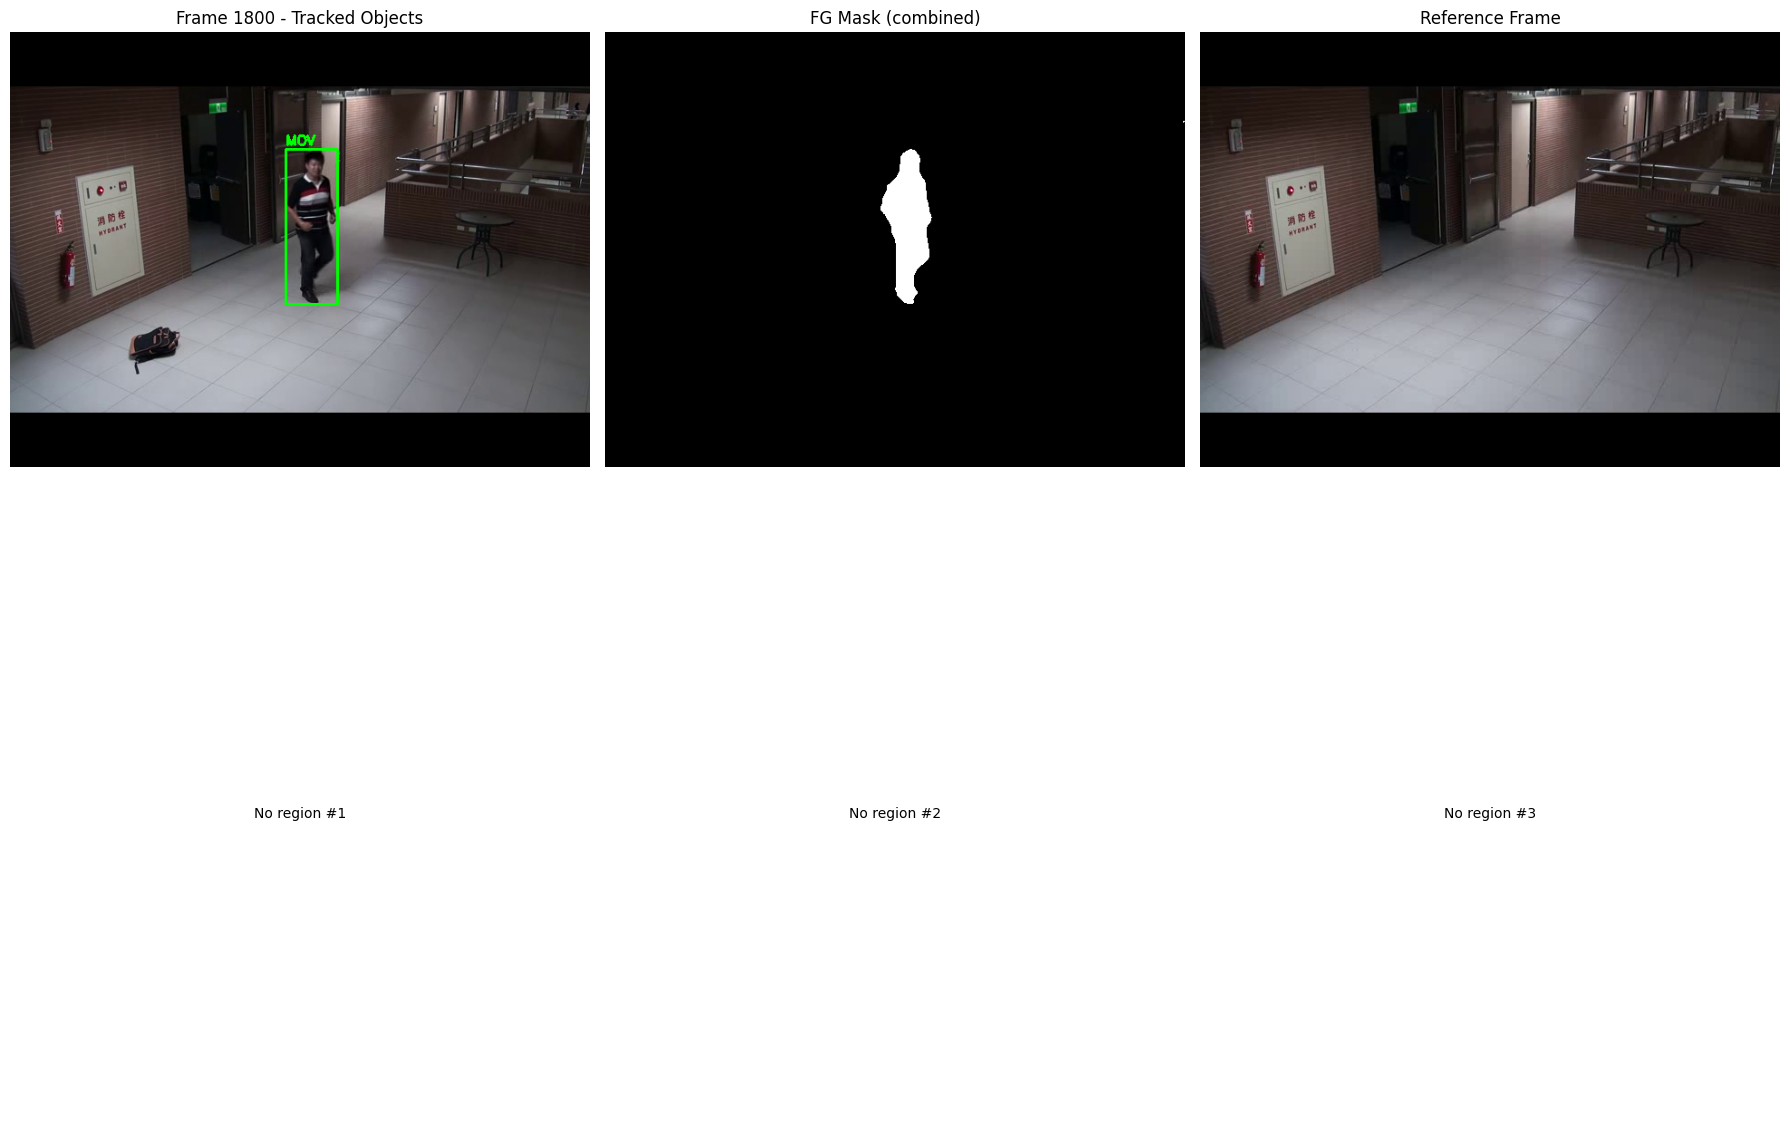

\n=== ANALIZA ZAKOŃCZONA ===


In [83]:
# DEBUG: Analiza check_stationary_regions
DEBUG_FRAMES_STAT = [800, 1000, 1200, 1500, 1800]
os.makedirs('Outputs/debug_stationary', exist_ok=True)

# Reset
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
backSub = cv2.createBackgroundSubtractorMOG2(
    history=MOG2_HISTORY,
    varThreshold=MOG2_VAR_THRESHOLD,
    detectShadows=MOG2_DETECT_SHADOWS
)

detector_debug = ObjectDetector(min_area=MIN_OBJECT_AREA, max_area=MAX_OBJECT_AREA, merge_distance=0)
tracker_debug = ObjectTracker(iou_threshold=IOU_THRESHOLD, stationary_threshold=STATIONARY_TIME_THRESHOLD, movement_threshold=5)

frame_count = 0

while cap.isOpened() and frame_count < max(DEBUG_FRAMES_STAT) + 1:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # Przetwarzanie
    fgMask = backSub.apply(frame)
    fgMask[fgMask == 127] = 0
    
    kernel_tiny = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    
    fgMask_small = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel_tiny, iterations=1)
    fgMask_large = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel_small, iterations=1)
    fgMask_large = cv2.morphologyEx(fgMask_large, cv2.MORPH_CLOSE, kernel_large, iterations=3)
    fgMask_combined = cv2.bitwise_or(fgMask_small, fgMask_large)
    
    detected_objects = detector_debug.detect_objects(fgMask_combined)
    tracked_objects = tracker_debug.update(detected_objects, frame_count)
    
    if frame_count not in DEBUG_FRAMES_STAT:
        continue
    
    print(f"\\n=== STATIONARY DEBUG Frame {frame_count} ===")
    print(f"Tracked objects: {len(tracked_objects)}")
    print(f"Stationary regions: {len(tracker_debug.stationary_regions)}")
    
    # Wizualizacja 2x3
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Obecna klatka z wykrytymi obiektami
    frame_vis = frame.copy()
    for obj in tracked_objects:
        x, y, w, h = obj['bbox']
        color = (0, 0, 255) if obj['is_stationary'] else (0, 255, 0)
        cv2.rectangle(frame_vis, (x, y), (x+w, y+h), color, 2)
        label = f"S:{obj['frames_stationary']}" if obj['is_stationary'] else "MOV"
        cv2.putText(frame_vis, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    axes[0, 0].imshow(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title(f'Frame {frame_count} - Tracked Objects')
    axes[0, 0].axis('off')
    
    # 2. FG Mask
    axes[0, 1].imshow(fgMask_combined, cmap='gray')
    axes[0, 1].set_title('FG Mask (combined)')
    axes[0, 1].axis('off')
    
    # 3. Referencja
    axes[0, 2].imshow(cv2.cvtColor(reference_frame, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title('Reference Frame')
    axes[0, 2].axis('off')
    
    # 4-6. Analiza każdego stacjonarnego regionu
    stationary_list = [(tid, info) for tid, info in tracker_debug.stationary_regions.items()]
    
    for idx in range(3):
        if idx < len(stationary_list):
            track_id, region_info = stationary_list[idx]
            x, y, w, h = region_info['bbox']
            
            # Wytnij regiony
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = min(frame.shape[1], x+w), min(frame.shape[0], y+h)
            
            if x2 > x1 and y2 > y1:
                current_region = frame[y1:y2, x1:x2]
                reference_region = reference_frame[y1:y2, x1:x2]
                
                # Różnica
                curr_gray = cv2.cvtColor(current_region, cv2.COLOR_BGR2GRAY)
                ref_gray = cv2.cvtColor(reference_region, cv2.COLOR_BGR2GRAY)
                diff = cv2.absdiff(curr_gray, ref_gray)
                _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
                
                diff_pixels = np.sum(thresh > 0)
                
                # Porównanie obok siebie
                comparison = np.hstack([
                    cv2.cvtColor(reference_region, cv2.COLOR_BGR2RGB),
                    cv2.cvtColor(current_region, cv2.COLOR_BGR2RGB),
                    cv2.cvtColor(cv2.applyColorMap(thresh, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
                ])
                
                axes[1, idx].imshow(comparison)
                axes[1, idx].set_title(f'ID:{track_id} | Diff:{diff_pixels}px\\nRef|Curr|Diff')
                axes[1, idx].axis('off')
                
                print(f"  Region {track_id}: bbox=({x},{y},{w},{h}), diff_pixels={diff_pixels}")
            else:
                axes[1, idx].text(0.5, 0.5, 'Invalid region', ha='center', va='center')
                axes[1, idx].axis('off')
        else:
            axes[1, idx].text(0.5, 0.5, f'No region #{idx+1}', ha='center', va='center')
            axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'Outputs/debug_stationary/frame_{frame_count:04d}_regions.png', dpi=150)
    plt.show()

cap.release()
print("\\n=== ANALIZA ZAKOŃCZONA ===")

In [ ]:
frame_count = 0
stats = {
    'moving_objects': [],
    'abandoned_objects': []
}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # MOG2 
    fgMask = backSub.apply(frame)
    fgMask[fgMask == 127] = 0
    
    # Czyszczenie od szumów
    kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))

    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_OPEN, kernel_small, iterations=2)
    fgMask = cv2.morphologyEx(fgMask, cv2.MORPH_CLOSE, kernel_large, iterations=2)
    
    # Detekcja obiektów (z automatycznym merge fragmentów)
    detected_objects = detector.detect_objects(fgMask)
    
    # Tracking - automatycznie zarządza stacjonarnością
    tracked_objects = static_tracker.update(detected_objects, frame_count)
    
    # Sprawdź regiony stacjonarne vs referencja (porzucone obiekty)
    abandoned_objects = static_tracker.check_stationary_regions(
        frame, reference_frame, frame_count, 
        check_interval=10, 
        min_diff_area=100
    )
    
    # Przygotuj maskę FG do wizualizacji
    fg_vis = cv2.cvtColor(fgMask, cv2.COLOR_GRAY2BGR)
    
    # Rysuj wszystkie wykryte obiekty
    for obj in tracked_objects:
        x, y, w, h = obj['bbox']
        center = obj['center']
        
        if obj['is_stationary']:
            # Sprawdź czy jest na liście abandoned
            is_abandoned = any(ab['id'] == obj['id'] for ab in abandoned_objects)
            
            if is_abandoned:
                # Czerwony - PORZUCONY (stacjonarny + różnica z referencją)
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 4)
                cv2.rectangle(frame, (x, y-60), (x+280, y), (0, 0, 255), -1)
                cv2.putText(frame, "! ABANDONED OBJECT !", (x+5, y-35), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                cv2.putText(frame, f"ID:{obj['id']} Time:{obj['frames_stationary']}f", (x+5, y-15), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
                
                if (frame_count // 5) % 2 == 0:
                    cv2.circle(frame, center, 10, (0, 0, 255), -1)
                    cv2.circle(frame, center, 15, (255, 255, 255), 2)
                
                cv2.rectangle(fg_vis, (x, y), (x+w, y+h), (0, 0, 255), 4)
                cv2.putText(fg_vis, "ABANDONED", (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            else:
                # Żółty - stacjonarny ale nie potwierdzony jako porzucony
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
                cv2.putText(frame, f"Static {obj['frames_stationary']}f", (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
                
                cv2.rectangle(fg_vis, (x, y), (x+w, y+h), (0, 255, 255), 2)
                cv2.putText(fg_vis, f"Static {obj['frames_stationary']}f", (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)
        else:
            # Zielony - ruchomy
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, "MOVING", (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            cv2.rectangle(fg_vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(fg_vis, "MOVING", (x, y-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Info bar
    info_bg = frame.copy()
    cv2.rectangle(info_bg, (0, 0), (frame_width, 60), (0, 0, 0), -1)
    frame = cv2.addWeighted(frame, 0.7, info_bg, 0.3, 0)
    
    cv2.putText(frame, f"Frame: {frame_count}/{total_frames}", (10, 25), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    cv2.putText(frame, f"ABANDONED: {len(abandoned_objects)} | Tracked: {len(tracked_objects)}", (10, 50), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    # Info bar FG
    info_bg_fg = fg_vis.copy()
    cv2.rectangle(info_bg_fg, (0, 0), (frame_width, 60), (0, 0, 0), -1)
    fg_vis = cv2.addWeighted(fg_vis, 0.7, info_bg_fg, 0.3, 0)
    
    cv2.putText(fg_vis, f"Frame: {frame_count}/{total_frames} - FG MASK", (10, 25), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    cv2.putText(fg_vis, f"ABANDONED: {len(abandoned_objects)} | Tracked: {len(tracked_objects)}", (10, 50), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    
    out.write(frame)
    out_fg.write(fg_vis)
    
    stats['moving_objects'].append(len(detected_objects))
    stats['abandoned_objects'].append(len(abandoned_objects))
    
    if frame_count % 200 == 0:
        print(f"Processed {frame_count}/{total_frames} frames ({100*frame_count/total_frames:.1f}%)")

cap.release()
out.release()
out_fg.release()

Processed 200/2189 frames (9.1%)
Processed 400/2189 frames (18.3%)
Processed 400/2189 frames (18.3%)
Processed 600/2189 frames (27.4%)
Processed 600/2189 frames (27.4%)
Processed 800/2189 frames (36.5%)
Processed 800/2189 frames (36.5%)
Processed 1000/2189 frames (45.7%)
Processed 1000/2189 frames (45.7%)
Processed 1200/2189 frames (54.8%)
Processed 1200/2189 frames (54.8%)
Processed 1400/2189 frames (64.0%)
Processed 1400/2189 frames (64.0%)
Processed 1600/2189 frames (73.1%)
Processed 1600/2189 frames (73.1%)
Processed 1800/2189 frames (82.2%)
Processed 1800/2189 frames (82.2%)
Processed 2000/2189 frames (91.4%)
Processed 2000/2189 frames (91.4%)


## Wizualizacja statystyk

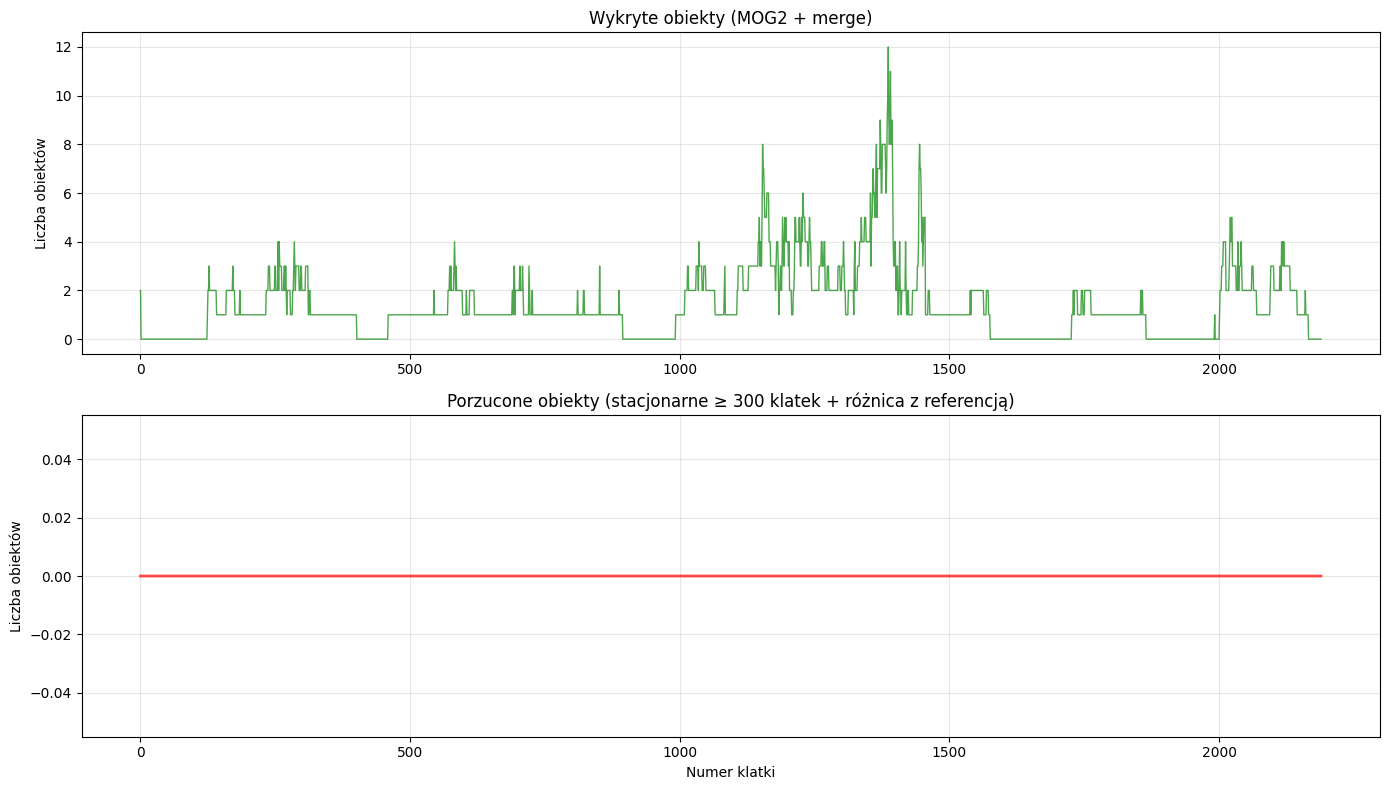

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

frames = list(range(1, len(stats['moving_objects']) + 1))

axes[0].plot(frames, stats['moving_objects'], color='green', alpha=0.7, linewidth=1)
axes[0].set_ylabel('Liczba obiektów')
axes[0].set_title('Wykryte obiekty (MOG2 + merge)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(frames, stats['abandoned_objects'], color='red', alpha=0.7, linewidth=2)
axes[1].set_xlabel('Numer klatki')
axes[1].set_ylabel('Liczba obiektów')
axes[1].set_title(f'Porzucone obiekty (stacjonarne ≥ {STATIONARY_TIME_THRESHOLD} klatek + różnica z referencją)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()